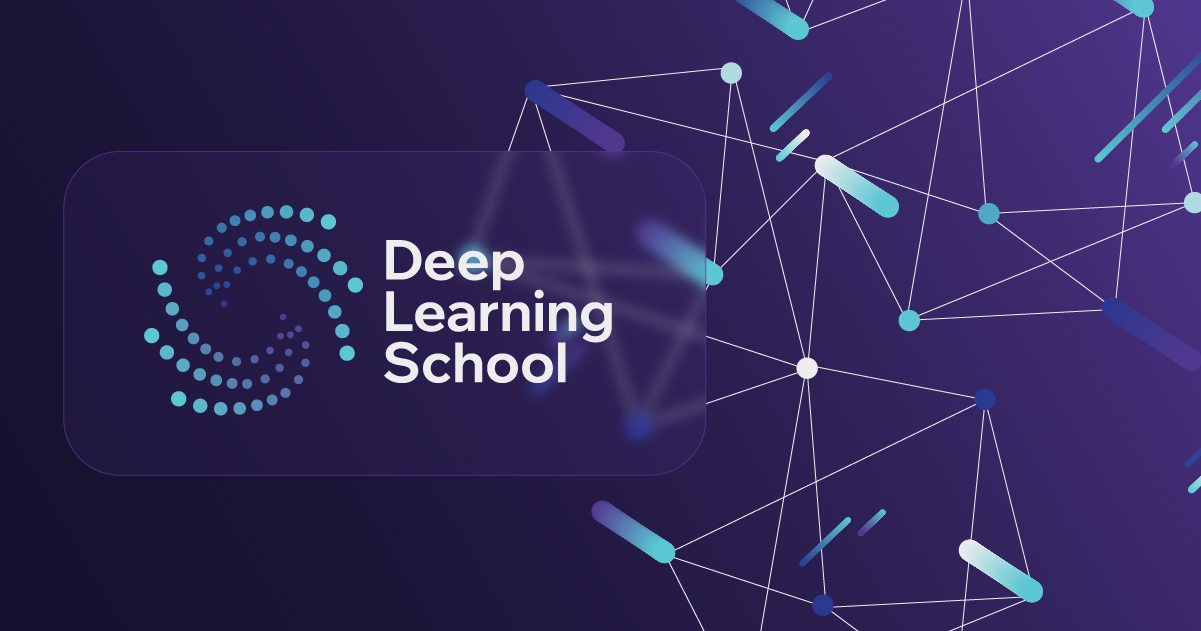


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import imageio
from PIL import Image
import kagglehub

%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [ ]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [ ]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [ ]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [ ]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [ ]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
def show_images(img_array, n=5):
  plt.figure(figsize=(15, 3))
  for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(img_array[i])
    plt.axis('off')
  plt.show()

In [ ]:
train_images, val_images, train_attrs, val_attrs = train_test_split(
    images, attrs.values, test_size=0.2, random_state=42
)

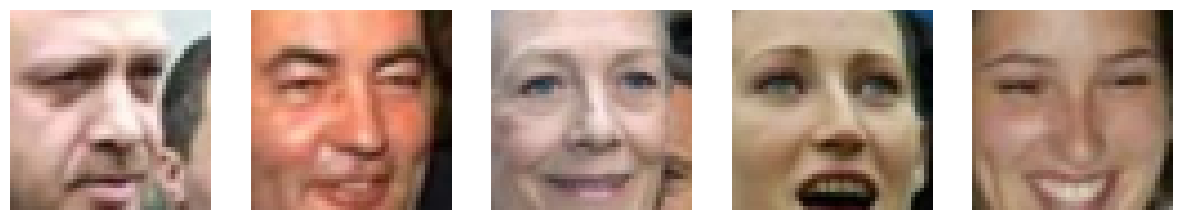

In [ ]:
show_images(train_images)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_tensors = torch.stack([transform(img) for img in train_images])
val_tensors = torch.stack([transform(img) for img in val_images])

print("Train tensor shape:", train_tensors.shape)
print("Val tensor shape:", val_tensors.shape)

Train tensor shape: torch.Size([10514, 3, 45, 45])
Val tensor shape: torch.Size([2629, 3, 45, 45])


## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



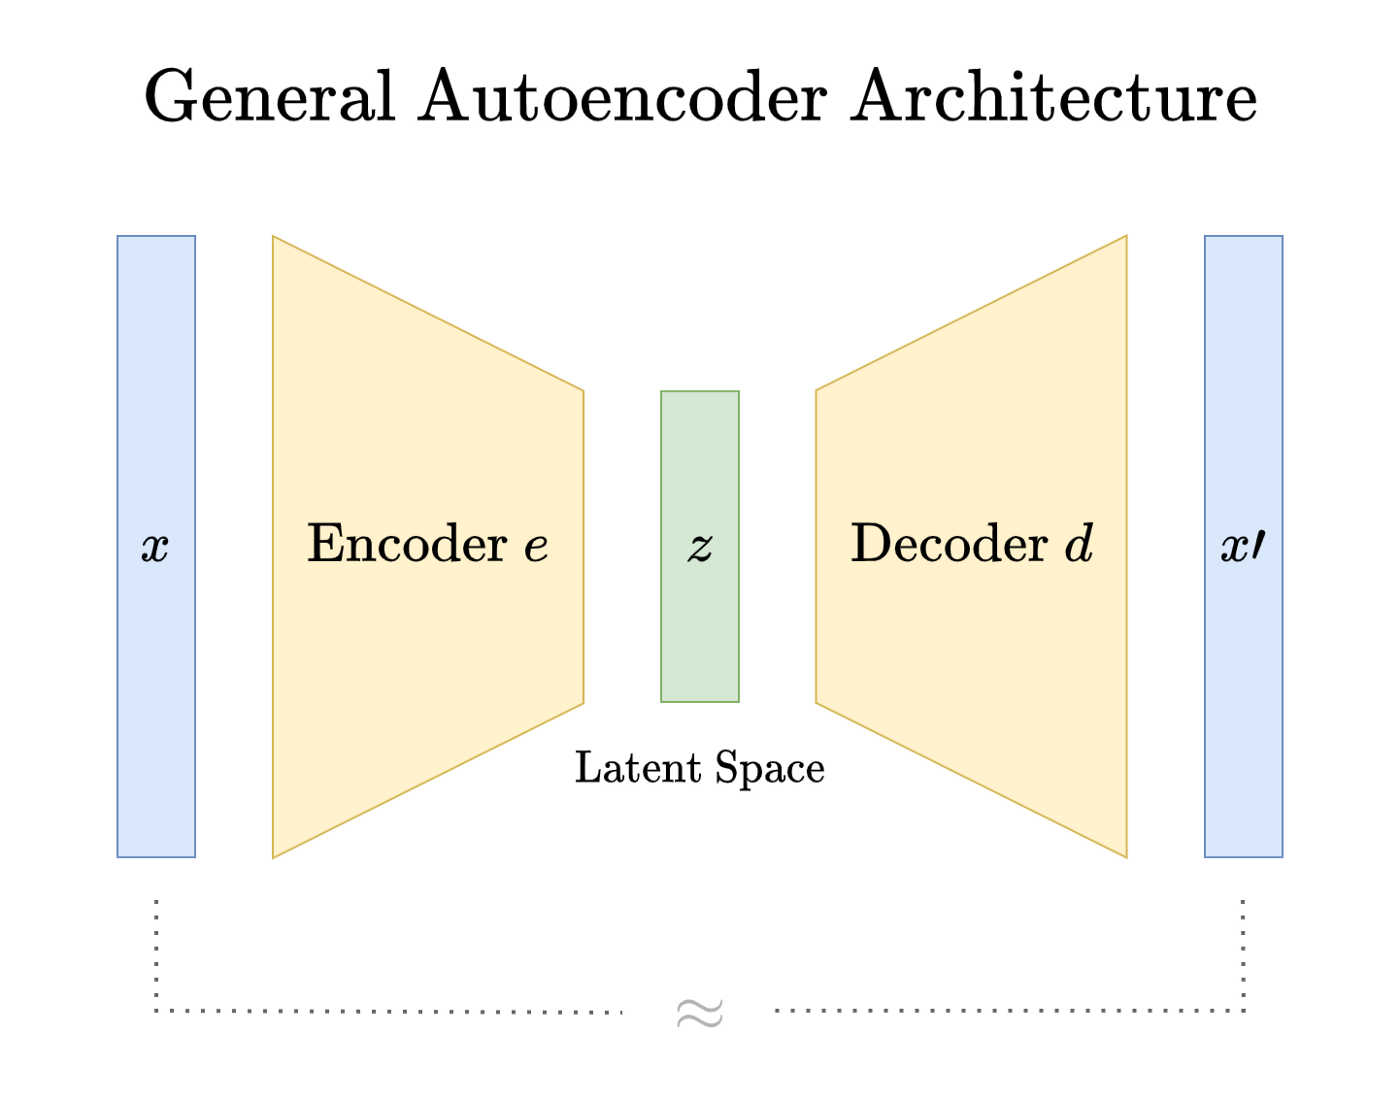

In [ ]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code:int=64):
        super().__init__()
        self.dim_code = dim_code
        self.flatten = nn.Flatten()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=45*45*3, out_features=6144),
            nn.ReLU(),
            nn.BatchNorm1d(6144),
            nn.Dropout(0.4),
            nn.Linear(in_features=6144, out_features=3072),
            nn.ReLU(),
            nn.BatchNorm1d(3072),
            nn.Dropout(0.3),
            nn.Linear(in_features=3072, out_features=1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(in_features=512, out_features=self.dim_code)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.dim_code, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024, out_features=3072),
            nn.ReLU(),
            nn.BatchNorm1d(3072),
            nn.Dropout(0.3),
            nn.Linear(in_features=3072, out_features=6144),
            nn.ReLU(),
            nn.BatchNorm1d(6144),
            nn.Dropout(0.4),
            nn.Linear(in_features=6144, out_features=45*45*3)
        )

    def forward(self, x):
        # encoding
        x = x.reshape(-1, 45*45*3)
        latent = self.encoder(x)

        # decoding
        reconstruction = self.decoder(latent)
        reconstruction = reconstruction.view(-1, 3, 45, 45)
        return reconstruction, latent

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def imshow(inp, title=None):
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

def train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cpu'):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        autoencoder.train()
        train_loss = 0.0
        for inputs in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()

            outputs, _ = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        autoencoder.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs in val_loader:
                inputs = inputs.to(device)
                outputs, _ = autoencoder(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if (epoch + 1) % 5 == 0:
          autoencoder.eval()
          with torch.no_grad():
              inputs = next(iter(val_loader))
              inputs = inputs.to(device)
              outputs, _ = autoencoder(inputs)

              inputs = inputs[:6]
              outputs = outputs[:6]

              fig, axes = plt.subplots(2, 6, figsize=(15, 5))
              for i in range(6):
                  axes[0, i].imshow(np.clip(inputs[i].permute(1, 2, 0).detach().cpu().numpy(), 0, 1))
                  axes[0, i].axis('off')
                  axes[1, i].imshow(np.clip(outputs[i].permute(1, 2, 0).detach().cpu().numpy(), 0, 1))
                  axes[1, i].axis('off')
              axes[0, 0].set_ylabel('Input', size='large')
              axes[1, 0].set_ylabel('Reconstruction', size='large')
              plt.suptitle(f'Reconstruction After Epoch {epoch+1}')
              plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.grid(True)
    plt.show()

Epoch [1/50], Train Loss: 0.3982, Val Loss: 0.1047
Epoch [2/50], Train Loss: 0.2063, Val Loss: 0.0857
Epoch [3/50], Train Loss: 0.1278, Val Loss: 0.0555
Epoch [4/50], Train Loss: 0.0892, Val Loss: 0.0470
Epoch [5/50], Train Loss: 0.0646, Val Loss: 0.0352


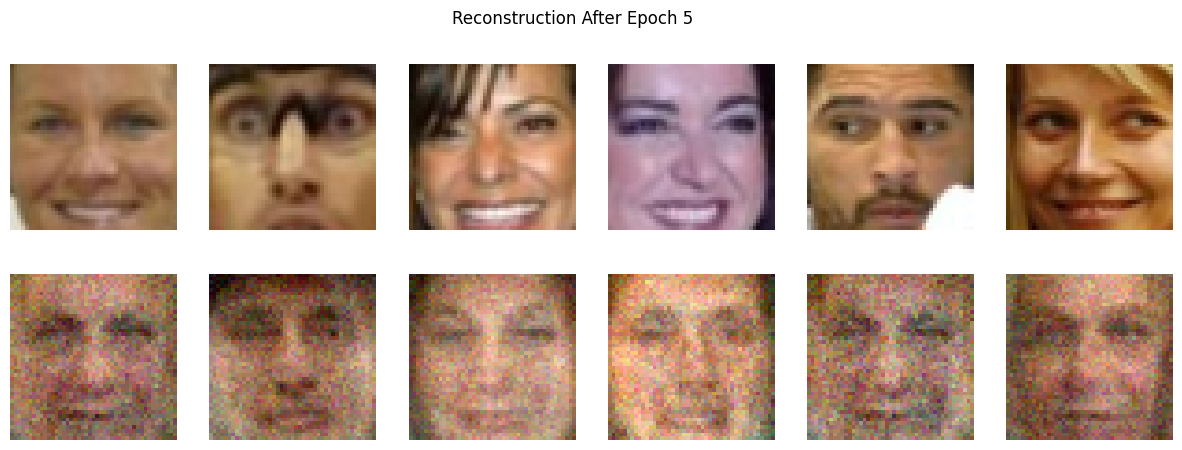

Epoch [6/50], Train Loss: 0.0532, Val Loss: 0.0397
Epoch [7/50], Train Loss: 0.0470, Val Loss: 0.0325
Epoch [8/50], Train Loss: 0.0440, Val Loss: 0.0301
Epoch [9/50], Train Loss: 0.0416, Val Loss: 0.0322
Epoch [10/50], Train Loss: 0.0413, Val Loss: 0.0288


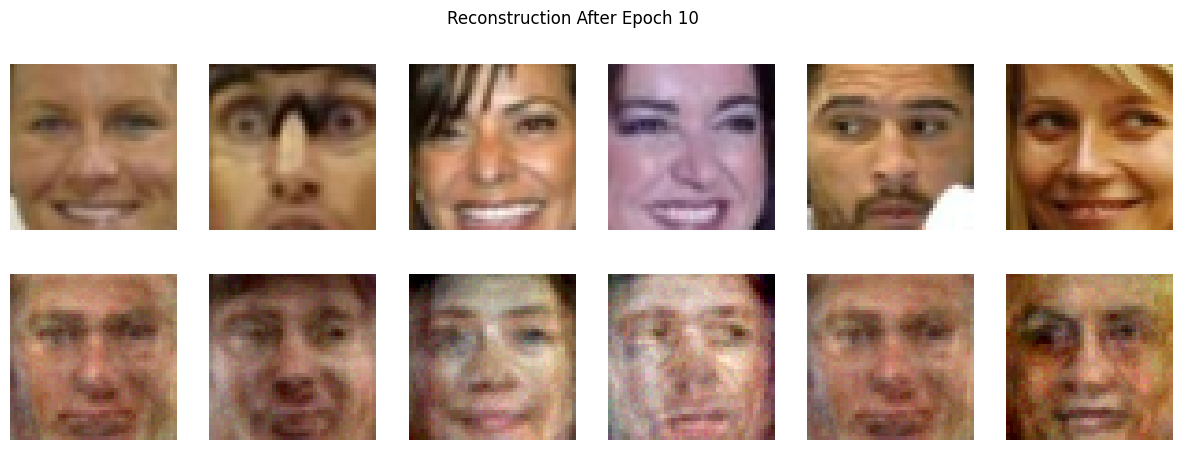

Epoch [11/50], Train Loss: 0.0402, Val Loss: 0.0273
Epoch [12/50], Train Loss: 0.0394, Val Loss: 0.0264
Epoch [13/50], Train Loss: 0.0372, Val Loss: 0.0275
Epoch [14/50], Train Loss: 0.0357, Val Loss: 0.0231
Epoch [15/50], Train Loss: 0.0330, Val Loss: 0.0227


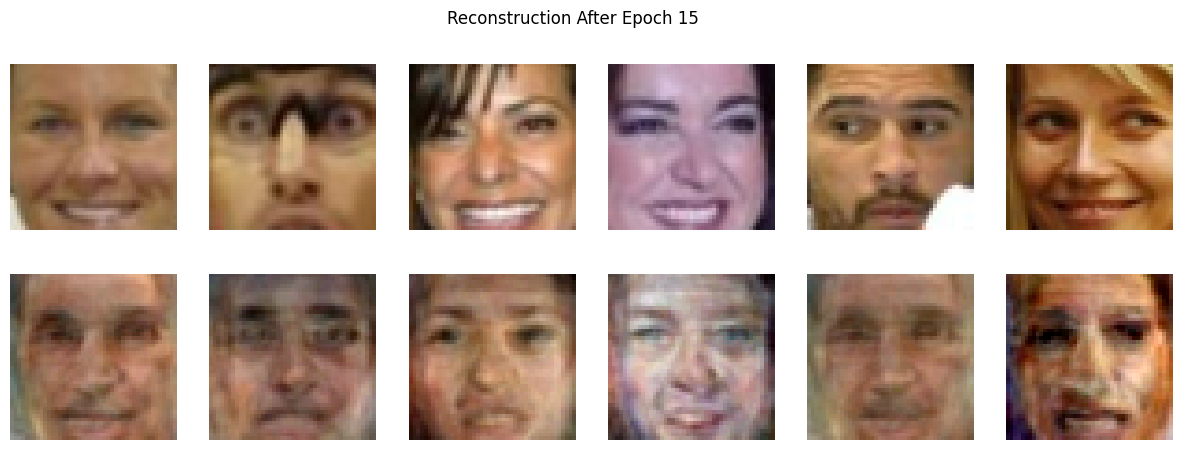

Epoch [16/50], Train Loss: 0.0297, Val Loss: 0.0229
Epoch [17/50], Train Loss: 0.0288, Val Loss: 0.0322
Epoch [18/50], Train Loss: 0.0281, Val Loss: 0.0293
Epoch [19/50], Train Loss: 0.0272, Val Loss: 0.0218
Epoch [20/50], Train Loss: 0.0255, Val Loss: 0.0196


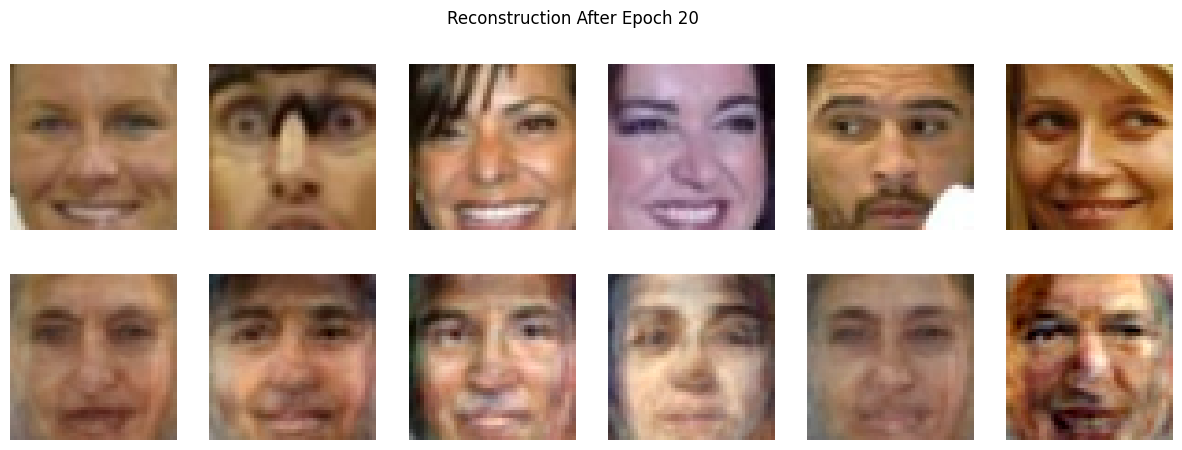

Epoch [21/50], Train Loss: 0.0244, Val Loss: 0.0266
Epoch [22/50], Train Loss: 0.0232, Val Loss: 0.0178
Epoch [23/50], Train Loss: 0.0218, Val Loss: 0.0181
Epoch [24/50], Train Loss: 0.0206, Val Loss: 0.0174
Epoch [25/50], Train Loss: 0.0197, Val Loss: 0.0164


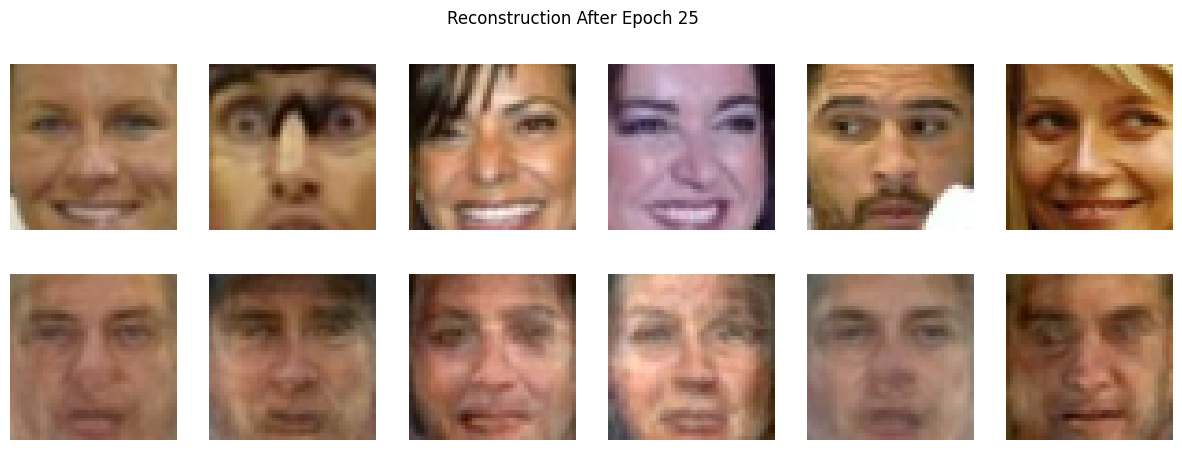

Epoch [26/50], Train Loss: 0.0187, Val Loss: 0.0166
Epoch [27/50], Train Loss: 0.0177, Val Loss: 0.0167
Epoch [28/50], Train Loss: 0.0168, Val Loss: 0.0160
Epoch [29/50], Train Loss: 0.0162, Val Loss: 0.0190
Epoch [30/50], Train Loss: 0.0155, Val Loss: 0.0145


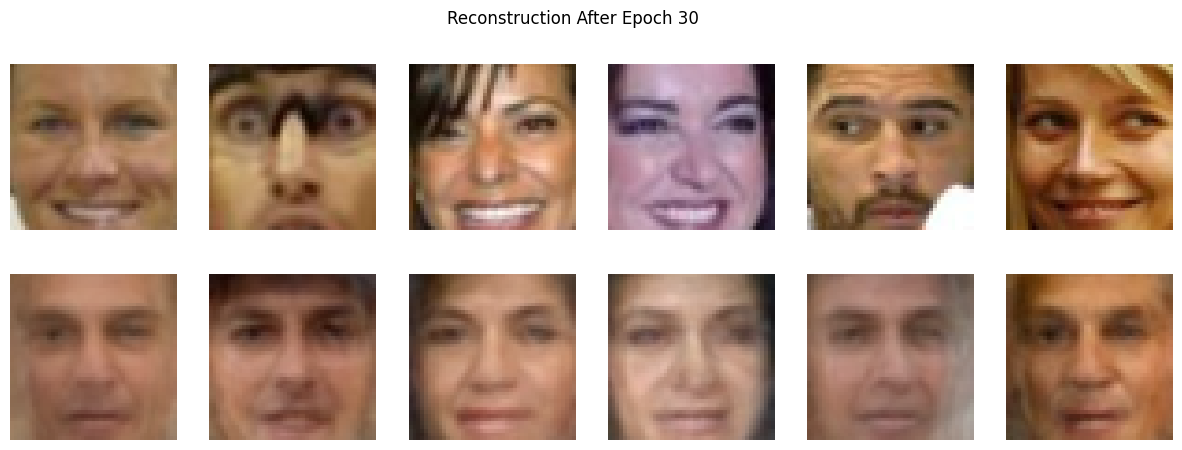

Epoch [31/50], Train Loss: 0.0149, Val Loss: 0.0138
Epoch [32/50], Train Loss: 0.0144, Val Loss: 0.0145
Epoch [33/50], Train Loss: 0.0139, Val Loss: 0.0138
Epoch [34/50], Train Loss: 0.0133, Val Loss: 0.0124
Epoch [35/50], Train Loss: 0.0127, Val Loss: 0.0126


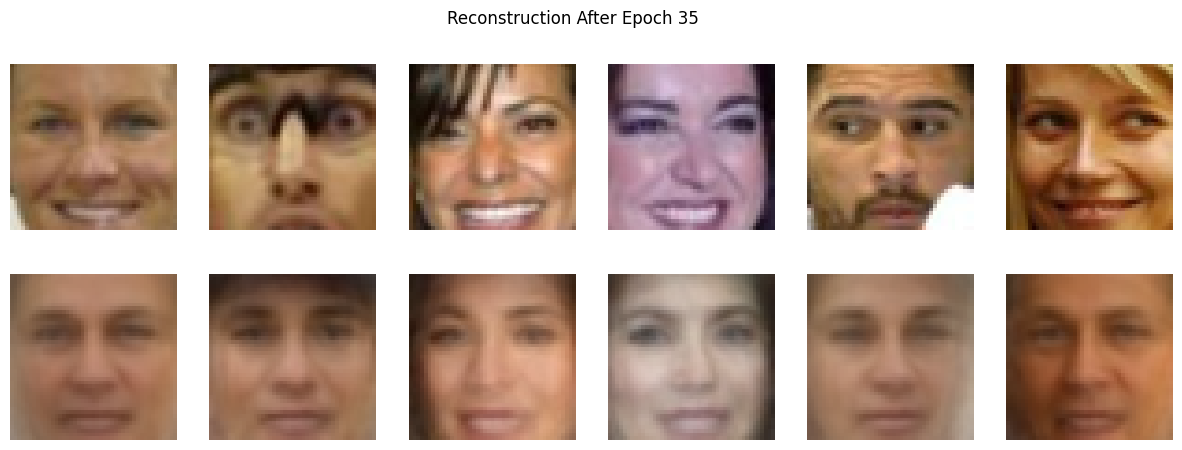

Epoch [36/50], Train Loss: 0.0124, Val Loss: 0.0120
Epoch [37/50], Train Loss: 0.0122, Val Loss: 0.0120
Epoch [38/50], Train Loss: 0.0120, Val Loss: 0.0119
Epoch [39/50], Train Loss: 0.0119, Val Loss: 0.0120
Epoch [40/50], Train Loss: 0.0118, Val Loss: 0.0129


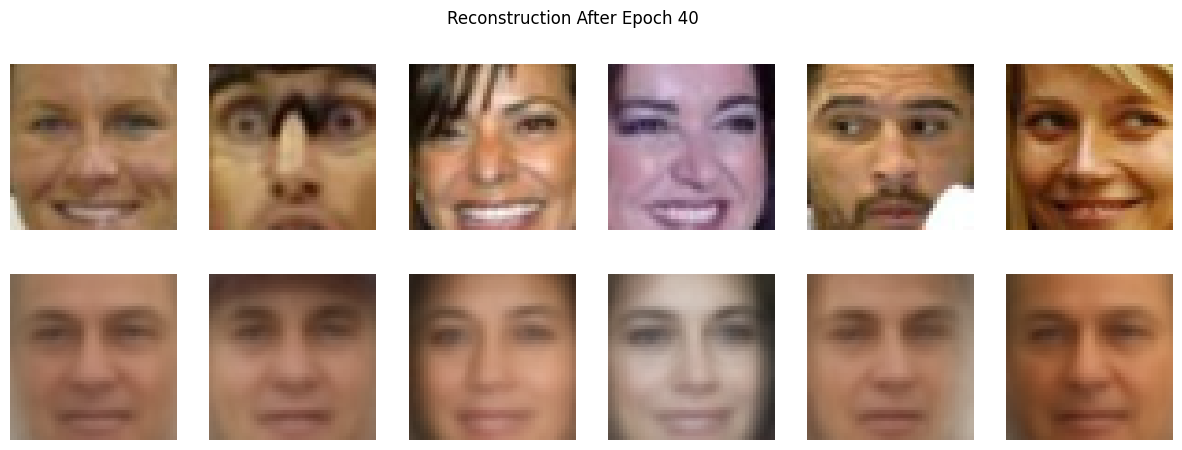

Epoch [41/50], Train Loss: 0.0117, Val Loss: 0.0114
Epoch [42/50], Train Loss: 0.0114, Val Loss: 0.0138
Epoch [43/50], Train Loss: 0.0112, Val Loss: 0.0139
Epoch [44/50], Train Loss: 0.0111, Val Loss: 0.0156
Epoch [45/50], Train Loss: 0.0112, Val Loss: 0.0119


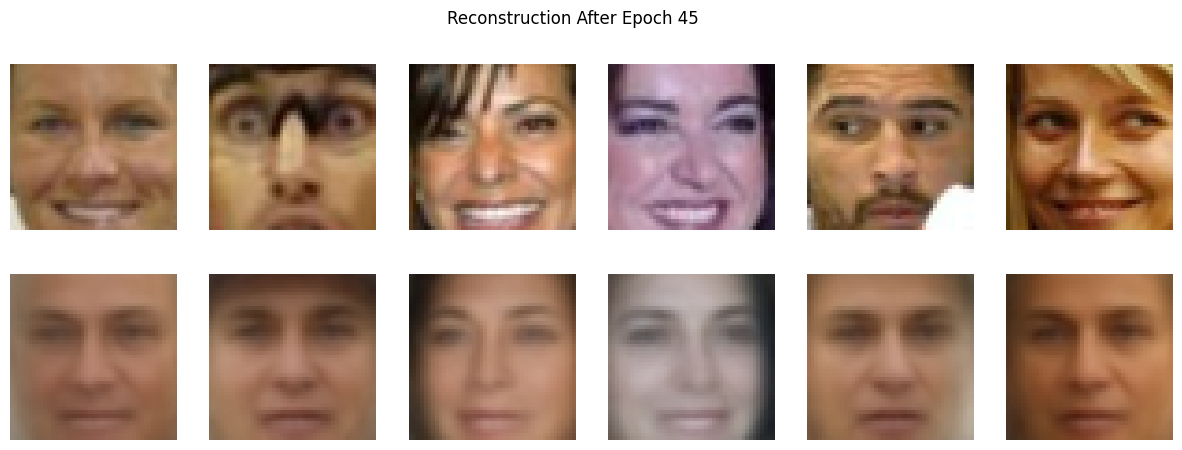

Epoch [46/50], Train Loss: 0.0110, Val Loss: 0.0116
Epoch [47/50], Train Loss: 0.0107, Val Loss: 0.0121
Epoch [48/50], Train Loss: 0.0107, Val Loss: 0.0112
Epoch [49/50], Train Loss: 0.0105, Val Loss: 0.0123
Epoch [50/50], Train Loss: 0.0102, Val Loss: 0.0141


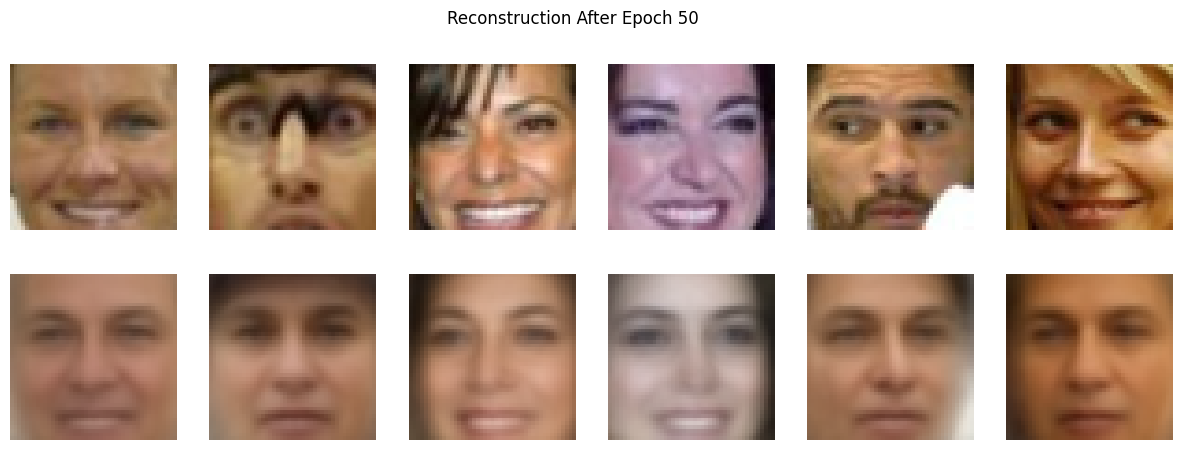

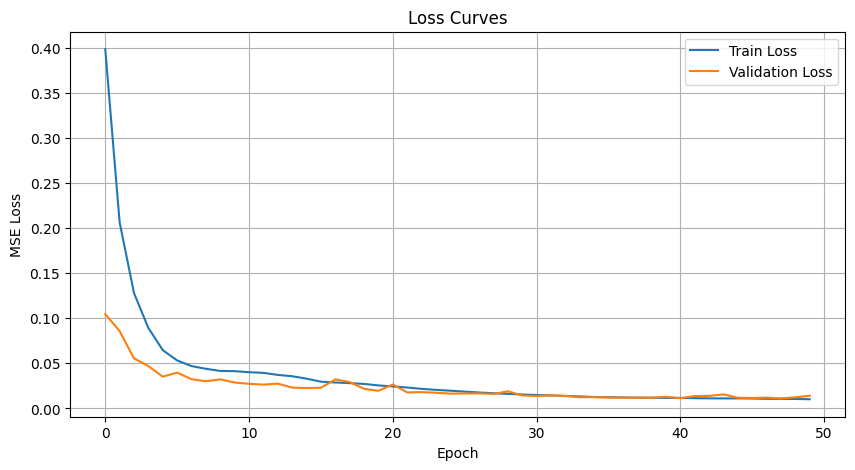

In [ ]:
train_loader = torch.utils.data.DataLoader(train_tensors, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_tensors, batch_size=64)

num_epochs = 50
train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

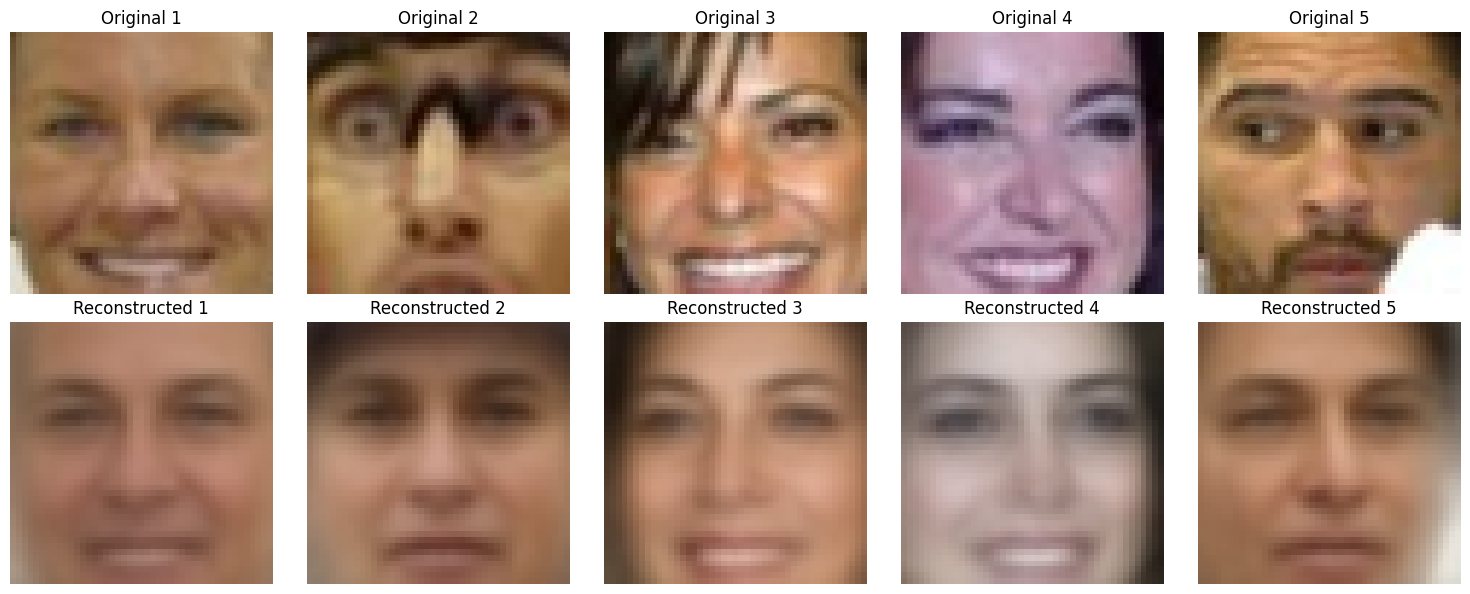

In [ ]:
def show_reconstructions(model, val_data, num_samples=5):
    samples = val_data[:num_samples].to(device)

    model.eval()
    with torch.no_grad():
        reconstructions, _ = model(samples)

    originals = samples.cpu().numpy().transpose(0, 2, 3, 1)
    recons = reconstructions.cpu().numpy().transpose(0, 2, 3, 1)

    plt.figure(figsize=(15, 6))

    for i in range(num_samples):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(originals[i])
        plt.title(f"Original {i+1}")
        plt.axis('off')

        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(recons[i])
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_reconstructions(autoencoder, val_tensors, num_samples=5)

Что вы можете сказать про результат?

Результат неплохой. За 50 эпох модель научилась более менее неплохо восстанавливать изображения, однако теряя некоторые отличительные черты.

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
def get_latent_stats(model, data_loader):
    latent_vectors = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            _, latent = model(batch)
            latent_vectors.append(latent.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors)
    mean = np.mean(latent_vectors, axis=0)
    std = np.std(latent_vectors, axis=0)
    return mean, std

def generate_new_faces(model, num_samples=25):
    z = np.random.randn(num_samples, model.dim_code) * latent_std + latent_mean
    z = torch.FloatTensor(z).to(device)

    model.eval()
    with torch.no_grad():
        generated = model.decoder(z)
        generated = generated.view(-1, 3, 45, 45)

    generated = generated.cpu().numpy().transpose(0, 2, 3, 1)

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Среднее латентных векторов: 0.0227 ± 0.2676
Стандартное отклонение: 4.0847 ± 0.9721


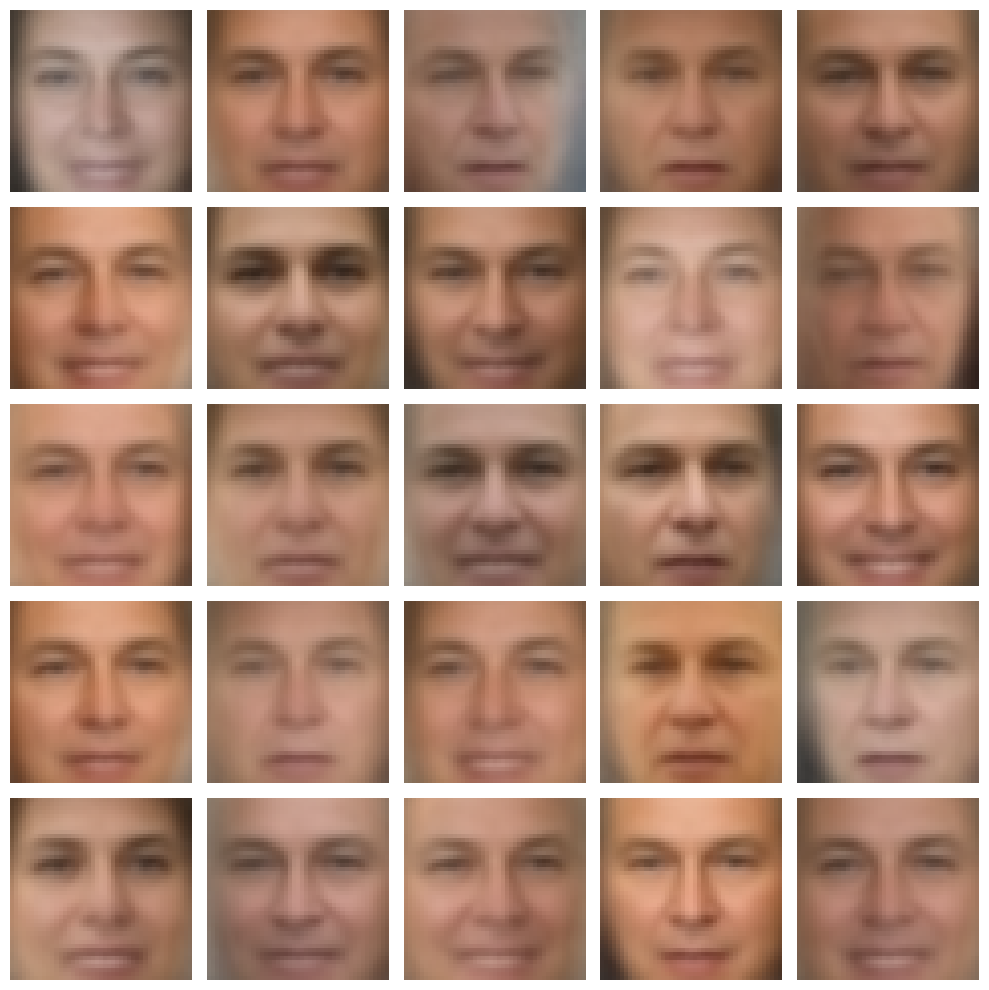

In [ ]:
latent_mean, latent_std = get_latent_stats(autoencoder, val_loader)
print(f"Среднее латентных векторов: {latent_mean.mean():.4f} ± {latent_mean.std():.4f}")
print(f"Стандартное отклонение: {latent_std.mean():.4f} ± {latent_std.std():.4f}")

generate_new_faces(autoencoder, num_samples=25)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
NUM_SAMPLES = 20

smiling_idx = attrs[attrs['Smiling'] > 2].sample(NUM_SAMPLES, random_state=42).index
not_smiling_idx = attrs[attrs['Smiling'] < -2].sample(NUM_SAMPLES, random_state=42).index

smiling_imgs = images[smiling_idx]
not_smiling_imgs = images[not_smiling_idx]

transform = transforms.Compose([
    transforms.ToTensor()
])

smiling_tensors = torch.stack([transform(img) for img in smiling_imgs]).to(device)
not_smiling_tensors = torch.stack([transform(img) for img in not_smiling_imgs]).to(device)

In [ ]:
autoencoder.eval()
with torch.no_grad():
    _, smiling_latents = autoencoder(smiling_tensors)
    _, not_smiling_latents = autoencoder(not_smiling_tensors)

smile_vector = smiling_latents.mean(dim=0) - not_smiling_latents.mean(dim=0)

In [ ]:
def add_smile(image_tensor, smile_vector, strength=1.0):
    autoencoder.eval()
    with torch.no_grad():
        _, latent = autoencoder(image_tensor.unsqueeze(0).to(device))
        modified_latent = latent + smile_vector.unsqueeze(0) * strength
        reconstruction = autoencoder.decoder(modified_latent)
        reconstruction = reconstruction.view(1, 3, 45, 45)
    return reconstruction.squeeze(0).cpu()

def tensor_to_image(tensor):
    img = tensor.permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    return img

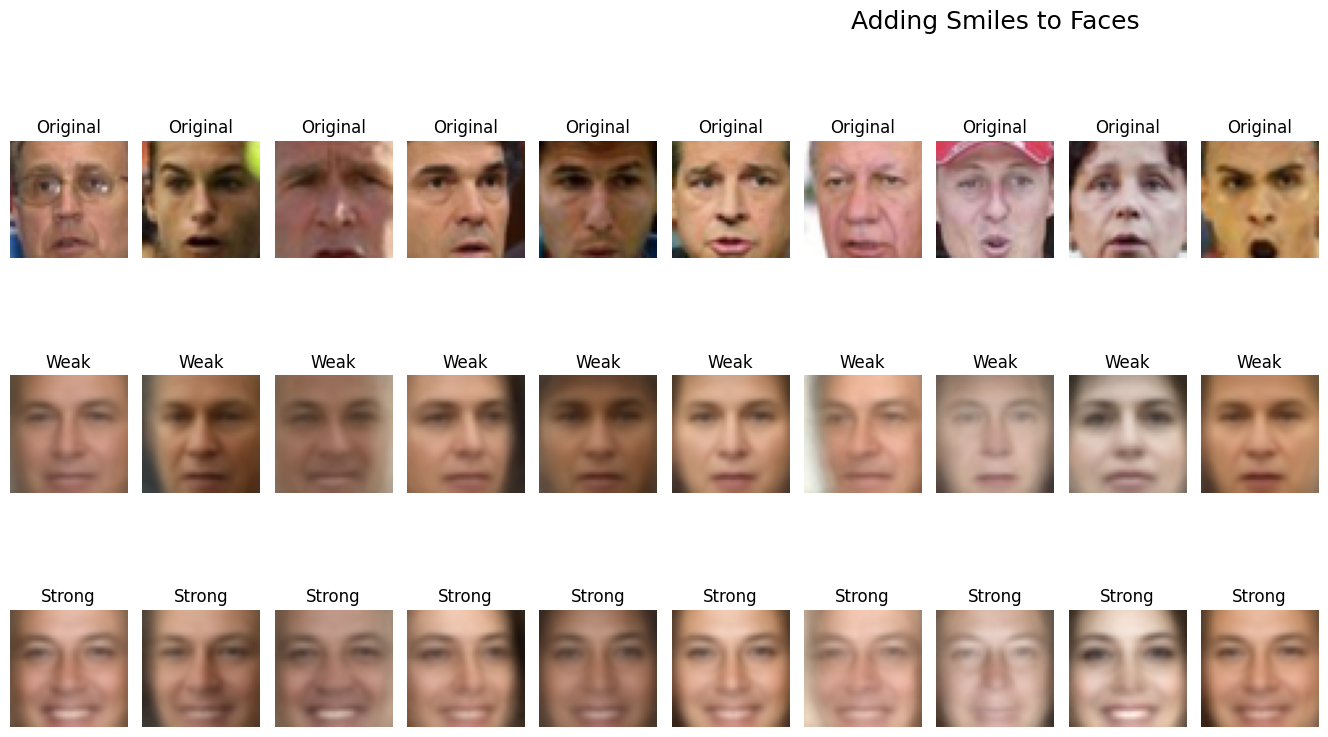

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(10):
    original = not_smiling_tensors[i].cpu()

    plt.subplot(3, 15, i + 1)
    plt.imshow(tensor_to_image(original))
    plt.title("Original")
    plt.axis('off')

    smile_weak = add_smile(original, smile_vector, strength=0.2)
    plt.subplot(3, 15, i + 16)
    plt.imshow(tensor_to_image(smile_weak))
    plt.title("Weak")
    plt.axis('off')

    smile_strong = add_smile(original, smile_vector, strength=2)
    plt.subplot(3, 15, i + 31)
    plt.imshow(tensor_to_image(smile_strong))
    plt.title("Strong")
    plt.axis('off')

plt.suptitle("Adding Smiles to Faces", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [3]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.83MB/s]


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, stride=2, padding=1),
                nn.ReLU(),
            )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logsigma = nn.Linear(64 * 7 * 7, latent_dim)

        # decoder
        self.fc_decoder = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),   # -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    sigma_squared = torch.exp(2 * logsigma)
    kl = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - sigma_squared, dim=1)
    return kl.mean()

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    return F.binary_cross_entropy(reconstruction, x, reduction='sum') / x.size(0)

def loss_vae(x, mu, logsigma, reconstruction):
    ll = log_likelihood(x, reconstruction)
    kl = KL_divergence(mu, logsigma)
    return ll + kl

И обучим модель:

In [ ]:
latent_dim = 32
num_epochs = 10

train_losses = []
log_likelihoods = []
kl_divergences = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = loss_vae

autoencoder = VAE(latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
def show_reconstructions(model, data_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        _, _, reconstruction = model(x)

        x = x[:num_images].cpu()
        reconstruction = reconstruction[:num_images].cpu()

        fig, axs = plt.subplots(2, num_images, figsize=(num_images, 2))
        for i in range(num_images):
            axs[0, i].imshow(x[i].squeeze(), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(reconstruction[i].squeeze(), cmap='gray')
            axs[1, i].axis('off')
        axs[0, 0].set_title('Original')
        axs[1, 0].set_title('Reconstruction')
        plt.show()

Epoch [1/10] | Loss: 121.0720 | LL: 90.1259 | KL: 30.9460
Epoch [2/10] | Loss: 120.4512 | LL: 89.5751 | KL: 30.8761


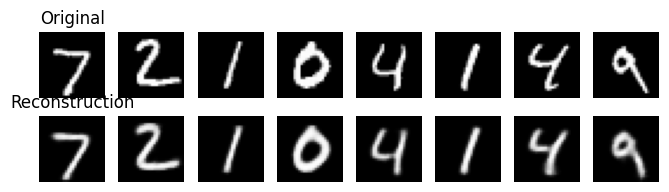

Epoch [3/10] | Loss: 119.9739 | LL: 89.1617 | KL: 30.8121
Epoch [4/10] | Loss: 119.6829 | LL: 88.8350 | KL: 30.8479


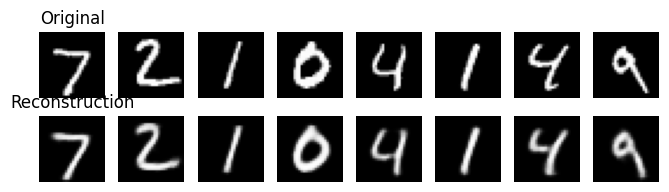

Epoch [5/10] | Loss: 119.3226 | LL: 88.5196 | KL: 30.8030
Epoch [6/10] | Loss: 119.0148 | LL: 88.2608 | KL: 30.7540


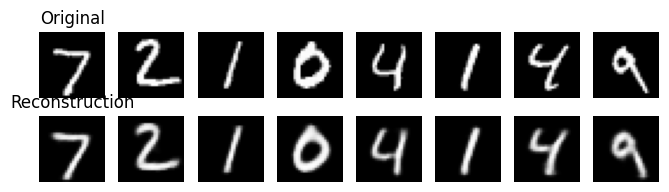

Epoch [7/10] | Loss: 118.7511 | LL: 88.0261 | KL: 30.7251
Epoch [8/10] | Loss: 118.5434 | LL: 87.8173 | KL: 30.7262


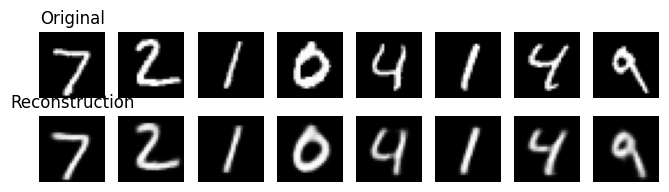

Epoch [9/10] | Loss: 118.3494 | LL: 87.6300 | KL: 30.7194
Epoch [10/10] | Loss: 118.1878 | LL: 87.4789 | KL: 30.7089


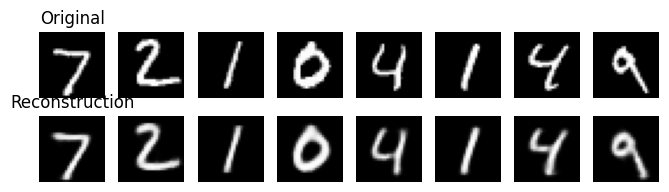

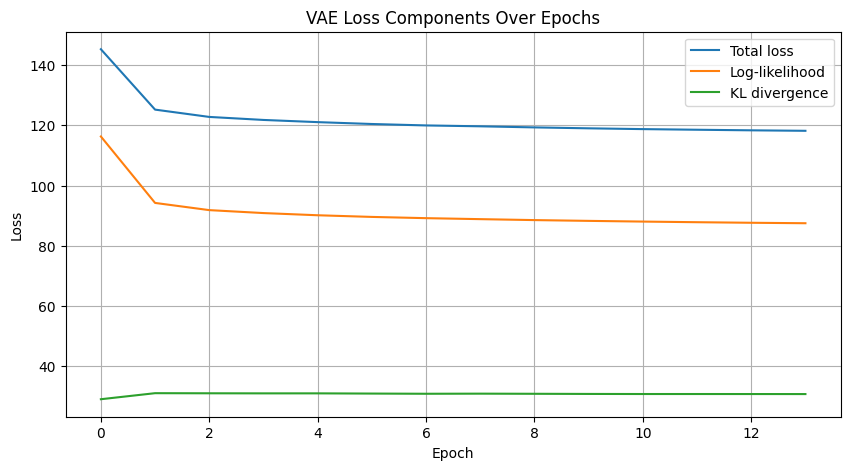

In [ ]:
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0
    total_ll = 0
    total_kl = 0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        mu, logsigma, reconstruction = autoencoder(x)

        ll = log_likelihood(x, reconstruction)
        kl = KL_divergence(mu, logsigma)
        loss = ll + kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ll += ll.item()
        total_kl += kl.item()

    avg_loss = total_loss / len(train_loader)
    avg_ll = total_ll / len(train_loader)
    avg_kl = total_kl / len(train_loader)

    train_losses.append(avg_loss)
    log_likelihoods.append(avg_ll)
    kl_divergences.append(avg_kl)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | LL: {avg_ll:.4f} | KL: {avg_kl:.4f}")

    if (epoch + 1) % 2 == 0:
      show_reconstructions(autoencoder, test_loader, num_images=8)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Total loss")
plt.plot(log_likelihoods, label="Log-likelihood")
plt.plot(kl_divergences, label="KL divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Loss Components Over Epochs")
plt.grid(True)
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
def show_vae_reconstructions(model, data_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        _, _, reconstruction = model(x)

        x = x[:num_images].cpu()
        reconstruction = reconstruction[:num_images].cpu()

        fig, axs = plt.subplots(2, num_images, figsize=(num_images * 1.5, 3))
        for i in range(num_images):
            axs[0, i].imshow(x[i].squeeze(), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(reconstruction[i].squeeze(), cmap='gray')
            axs[1, i].axis('off')
        axs[0, 0].set_title("Original")
        axs[1, 0].set_title("Reconstructed")
        plt.suptitle("VAE Reconstructions")
        plt.show()

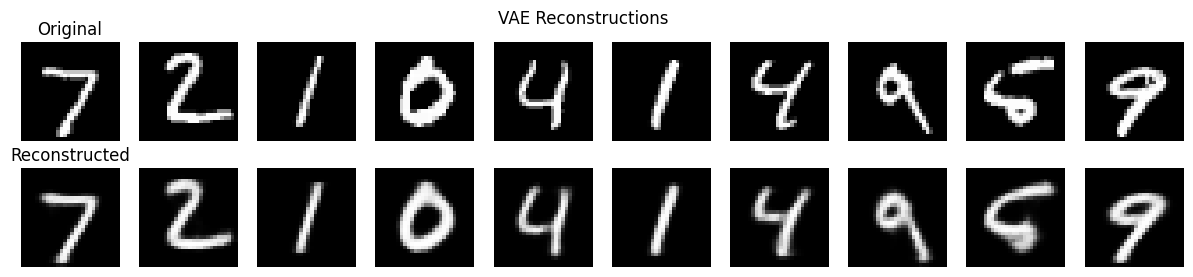

In [ ]:
show_vae_reconstructions(autoencoder, test_loader, num_images=10)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
def sample_from_latent(model, latent_dim=100, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()

        fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 1.5, 2))
        for i in range(num_samples):
            axs[i].imshow(samples[i].squeeze(), cmap='gray')
            axs[i].axis('off')
        plt.suptitle("Samples from VAE Decoder")
        plt.show()

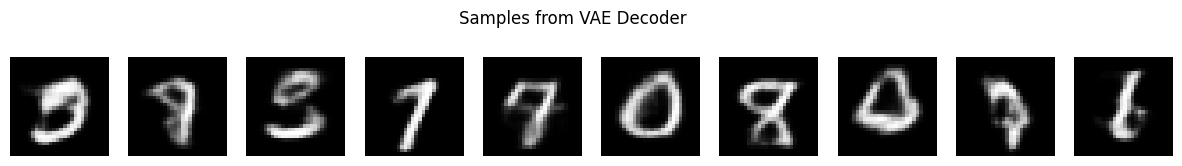

In [ ]:
sample_from_latent(autoencoder, latent_dim=32, num_samples=10)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
def extract_latent_vectors(model, data_loader, device, max_samples=1000):
    model.eval()
    latents = []
    labels = []
    total_collected = 0

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            mu, _, _ = model(x)
            latents.append(mu.cpu().numpy())
            labels.append(y.numpy())
            total_collected += x.size(0)
            if total_collected >= max_samples:
                break

    latents = np.concatenate(latents, axis=0)[:max_samples]
    labels = np.concatenate(labels, axis=0)[:max_samples]
    return latents, labels

def visualize_latents_tsne(latents, labels):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)
    plt.colorbar(scatter, ticks=range(10), label="Digit class")
    plt.title("t-SNE of Latent Vectors")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()

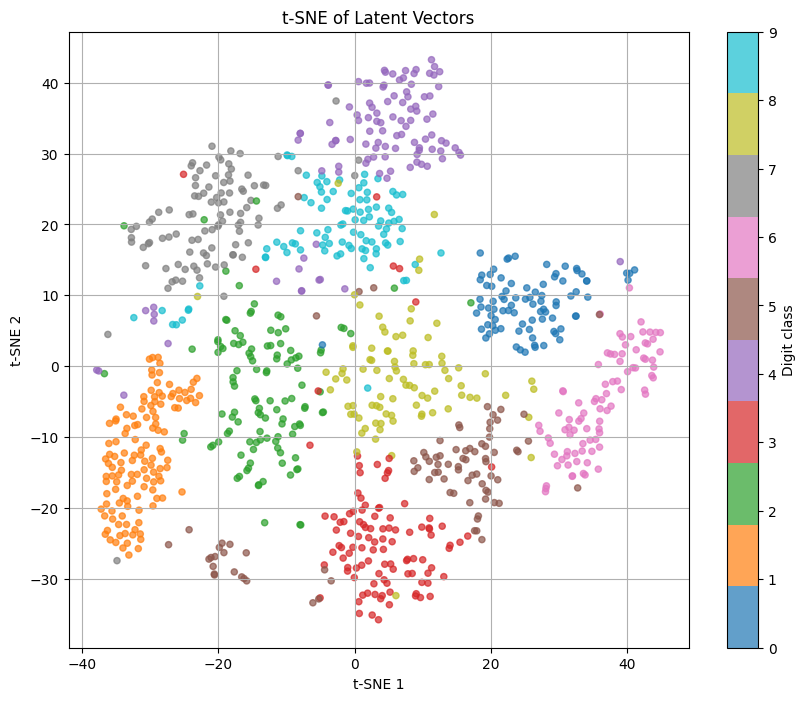

In [ ]:
latents, labels = extract_latent_vectors(autoencoder, test_loader, device, max_samples=1000)
visualize_latents_tsne(latents, labels)

Что вы думаете о виде латентного представления?

Классы целевых переменных распределились по своим кластерам. Есть незначительные пересечения, обусловленные похожестью некоторых цифр

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [11]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=32, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logsigma = nn.Linear(64 * 7 * 7, latent_dim)

        # decoder
        self.fc_decoder = nn.Linear(latent_dim + num_classes, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        y = class_num.view(class_num.size(0), self.num_classes, 1, 1).expand(-1, -1, 28, 28)
        x_cond = torch.cat([x, y], dim=1)
        h = self.encoder(x_cond)
        h = self.flatten(h)
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, y):
        z_cond = torch.cat([z, y], dim=1)
        x = self.fc_decoder(z_cond)
        x = x.view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x, y):
        mu, logsigma = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, y)
        return mu, logsigma, reconstruction

In [9]:
def loss_function(recon_x, x, mu, logsigma):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return recon_loss + kl_div

Epoch 1, Loss: 4118.2377
Epoch 2, Loss: 3400.0010


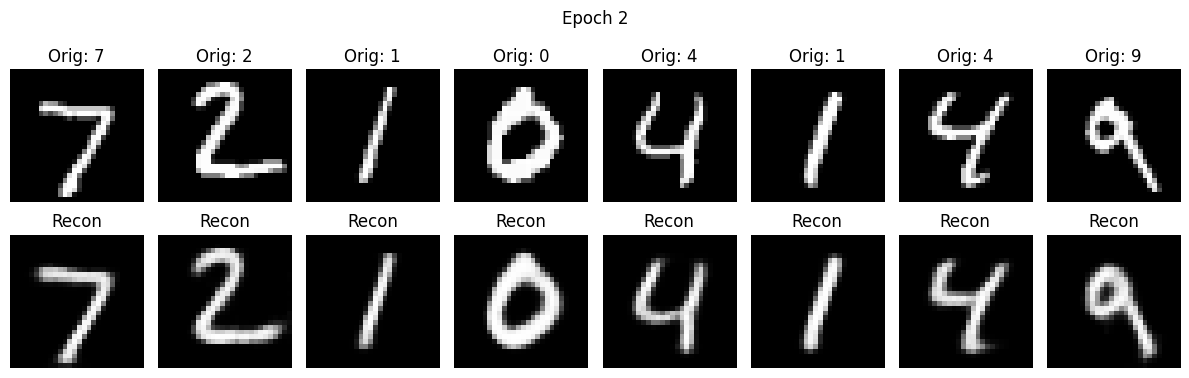

Epoch 3, Loss: 3311.0796
Epoch 4, Loss: 3268.2085


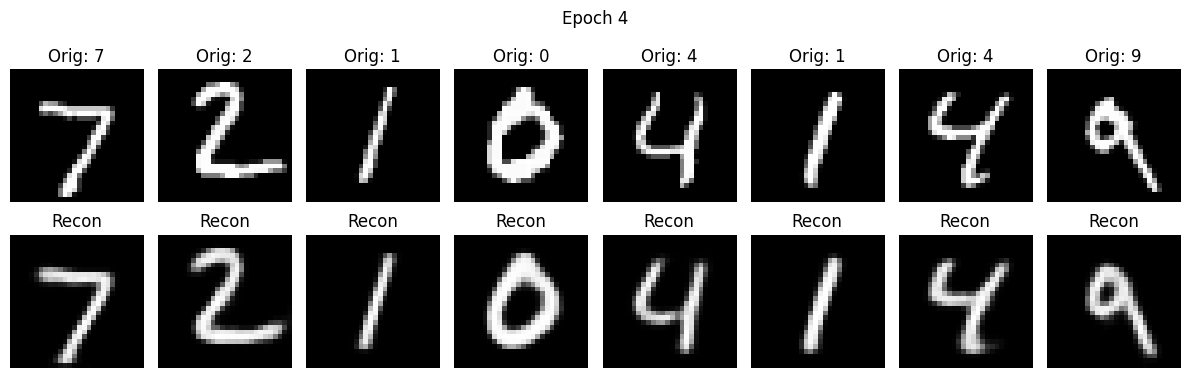

Epoch 5, Loss: 3240.2572
Epoch 6, Loss: 3219.9294


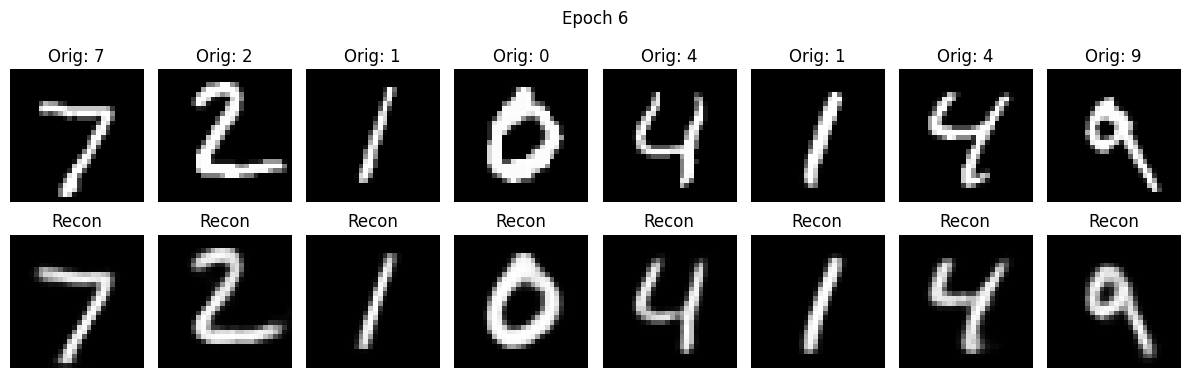

Epoch 7, Loss: 3200.8612
Epoch 8, Loss: 3187.2885


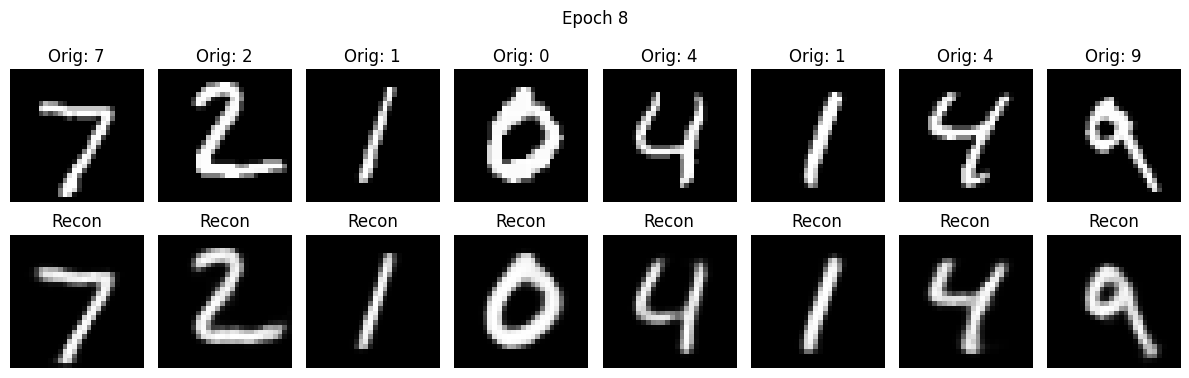

Epoch 9, Loss: 3176.6336
Epoch 10, Loss: 3164.2873


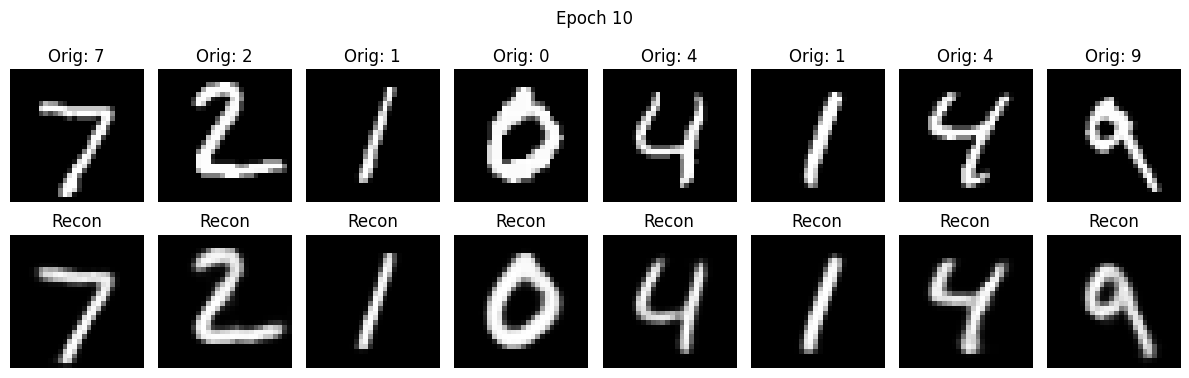

Epoch 11, Loss: 3155.3291
Epoch 12, Loss: 3145.8353


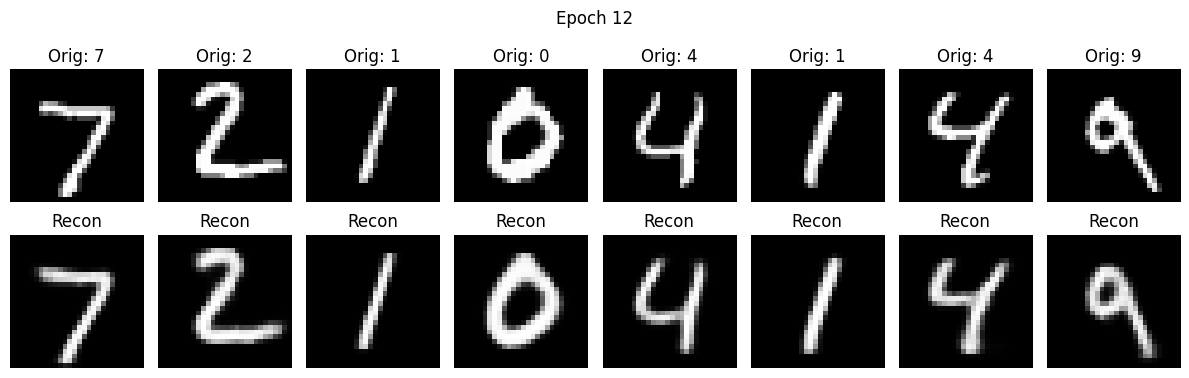

Epoch 13, Loss: 3140.0314
Epoch 14, Loss: 3131.8874


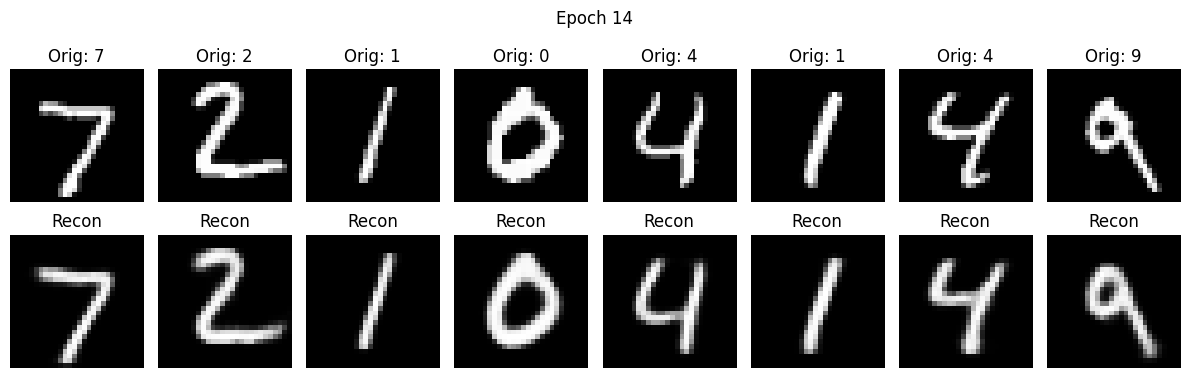

Epoch 15, Loss: 3126.2133
Epoch 16, Loss: 3120.7535


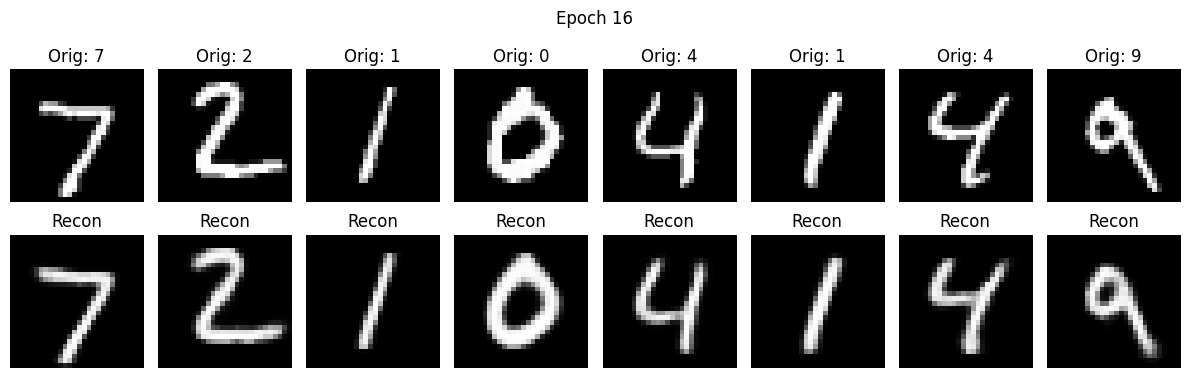

Epoch 17, Loss: 3115.9531
Epoch 18, Loss: 3110.8615


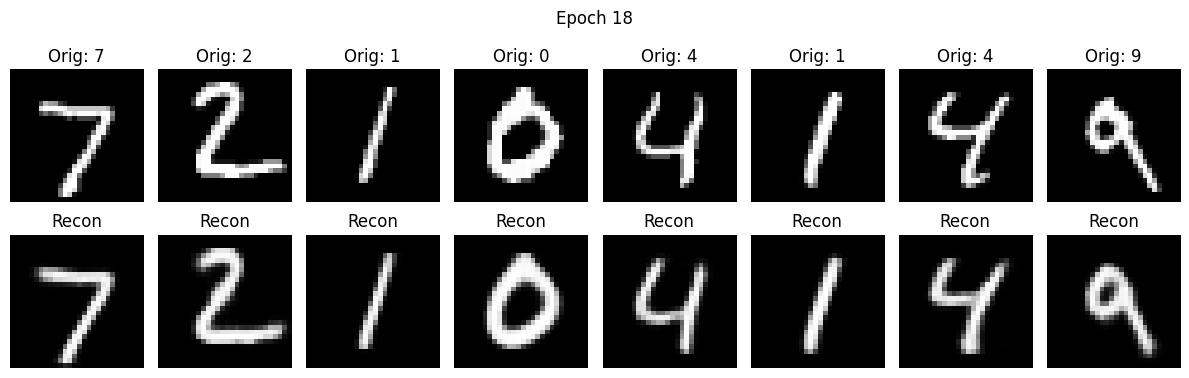

Epoch 19, Loss: 3104.9035
Epoch 20, Loss: 3100.7049


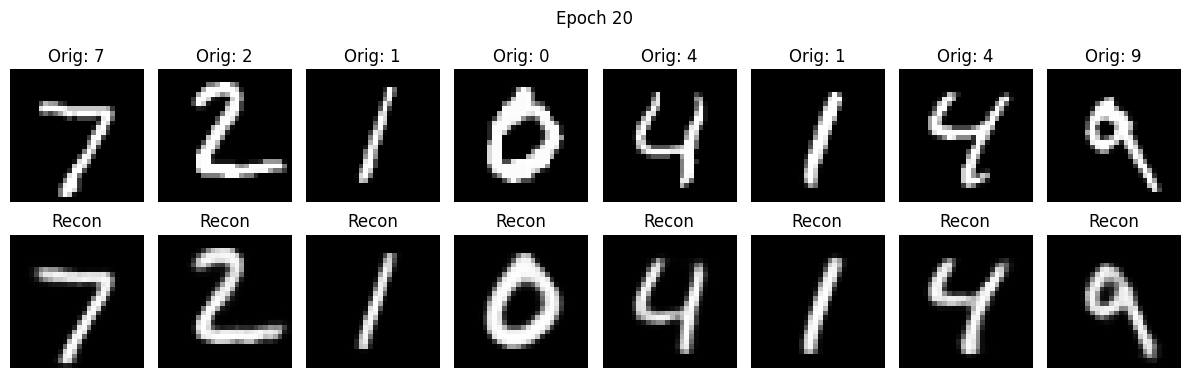

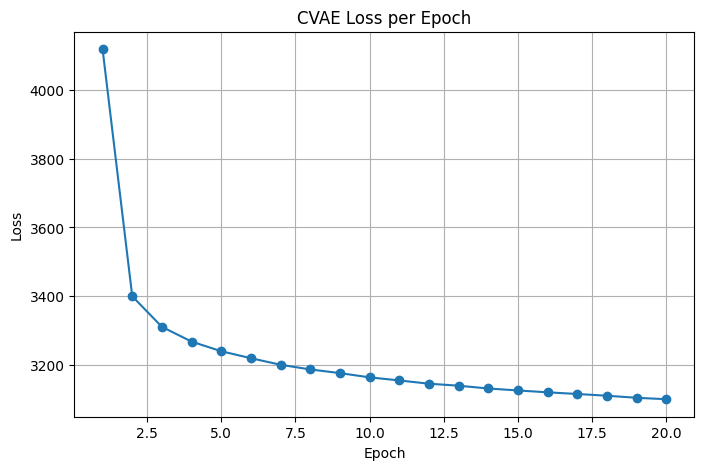

In [14]:
model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
epochs = 20

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0

    for x, labels in train_loader:
        x = x.to(device)
        y_onehot = F.one_hot(labels, num_classes=10).float().to(device)

        optimizer.zero_grad()
        mu, logsigma, recon_x = model(x, y_onehot)
        loss = loss_function(recon_x, x, mu, logsigma)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

    if epoch % 2 == 0:
        model.eval()
        with torch.no_grad():
            x_test, labels_test = next(iter(test_loader))
            x_test = x_test.to(device)
            y_test_onehot = F.one_hot(labels_test, num_classes=10).float().to(device)

            _, _, recon_test = model(x_test, y_test_onehot)

            fig, axes = plt.subplots(2, 8, figsize=(12, 4))
            for i in range(8):
                axes[0, i].imshow(x_test[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title(f"Orig: {labels_test[i].item()}")
                axes[0, i].axis('off')

                axes[1, i].imshow(recon_test[i].cpu().squeeze(), cmap='gray')
                axes[1, i].set_title("Recon")
                axes[1, i].axis('off')
            plt.suptitle(f"Epoch {epoch}")
            plt.tight_layout()
            plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("CVAE Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

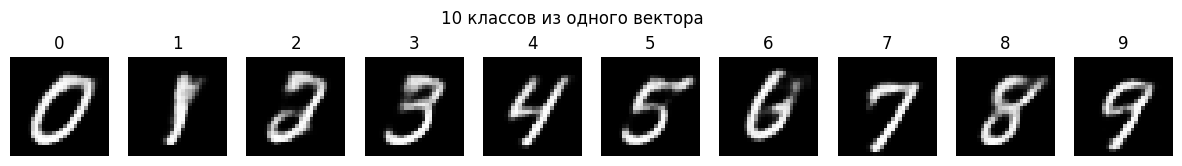

In [17]:
model.eval()
with torch.no_grad():
    z = torch.randn(1, 32).to(device)

    all_classes = torch.eye(10).to(device)

    z_expanded = z.repeat(10, 1)

    generated_imgs = model.decode(z_expanded, all_classes)

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(generated_imgs[i].cpu().squeeze(), cmap='gray')
        axes[i].set_title(str(i))
        axes[i].axis('off')
    plt.suptitle("10 классов из одного вектора")
    plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

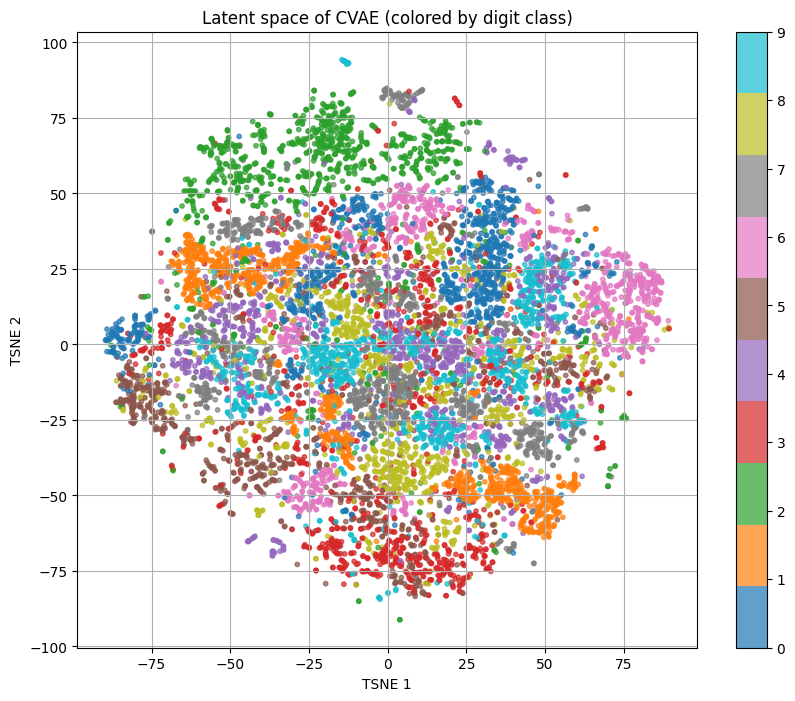

In [19]:
model.eval()
latents = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_onehot = F.one_hot(y, num_classes=10).float().to(device)

        mu, _ = model.encode(x, y_onehot)
        latents.append(mu.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("Latent space of CVAE (colored by digit class)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.grid(True)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>